In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Usando dispositivo: cpu
Unique values in 'Diabetes_012' after stripping and mapping:
['F' 'M']
NaN values in 'Diabetes_012' after stripping and mapping:
0

--- Conteo de valores para CLASS (Original antes de SMOTE): ---
CLASS
0    103
1     53
2    844
Name: count, dtype: int64

Iniciando balanceo con SMOTE...

--- Conteo de valores para CLASS (Después de SMOTE): ---
CLASS
0    844
1    844
2    844
Name: count, dtype: int64
Iniciando preprocesamiento...
Preprocesado Gender con One-Hot Encoding. Shape: (2532, 2)
Preprocesado AGE con log1p + MinMaxScaler. Shape: (2532, 1)
Preprocesado BMI con log1p + MinMaxScaler. Shape: (2532, 1)
Preprocesado Urea con MinMaxScaler. Shape: (2532, 1)
Preprocesado Cr con MinMaxScaler. Shape: (2532, 1)
Preprocesado HbA1c con MinMaxScaler. Shape: (2532, 1)
Preprocesado Chol con MinMaxScaler. Shape: (2532, 1)
Preprocesado TG con MinMaxScaler. Shape: (2532, 1)
Preprocesado HDL con MinMaxScaler. Shape: (2532, 1)
Preprocesado LDL con MinMaxScaler. Shape: (2532,

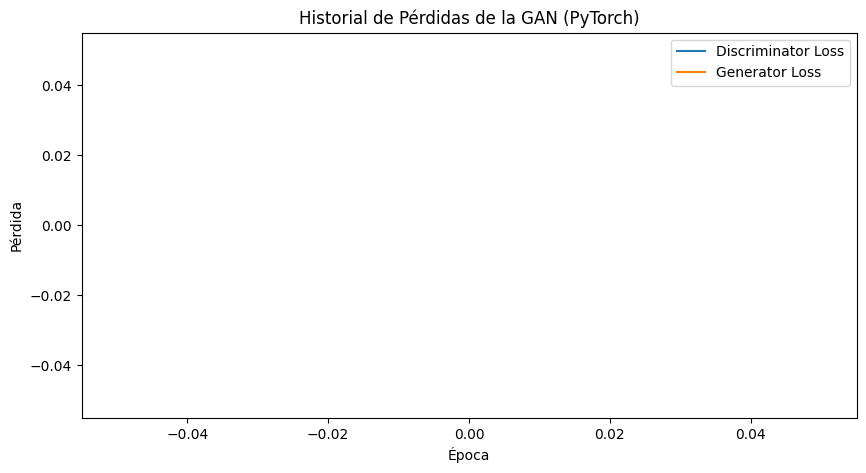


Generando datos sintéticos finales con PyTorch...
Value counts in temp_df_for_balancing['CLASS'] before balancing:
CLASS
0    50000
1    50000
2    50000
Name: count, dtype: int64

Datos sintéticos generados y guardados en: /content/gdrive/My Drive/ResultCSV/Multi/generated_data_gan_pytorch_0_3.csv

--- Descripción de los datos originales: ---
            Gender          AGE         Urea          Cr        HbA1c  \
count  2532.000000  2532.000000  2532.000000  2532.00000  2532.000000   
mean      0.422986    47.431675     4.722186    64.96406     6.480341   
std       0.494131     9.647218     2.272983    42.60856     2.275678   
min       0.000000    20.000000     0.500000     6.00000     0.900000   
25%       0.000000    41.000000     3.594724    48.00000     4.992159   
50%       0.000000    49.000000     4.395874    59.00000     6.000000   
75%       1.000000    54.000000     5.254985    73.00000     7.200000   
max       1.000000    79.000000    38.900000   800.00000    16.000000

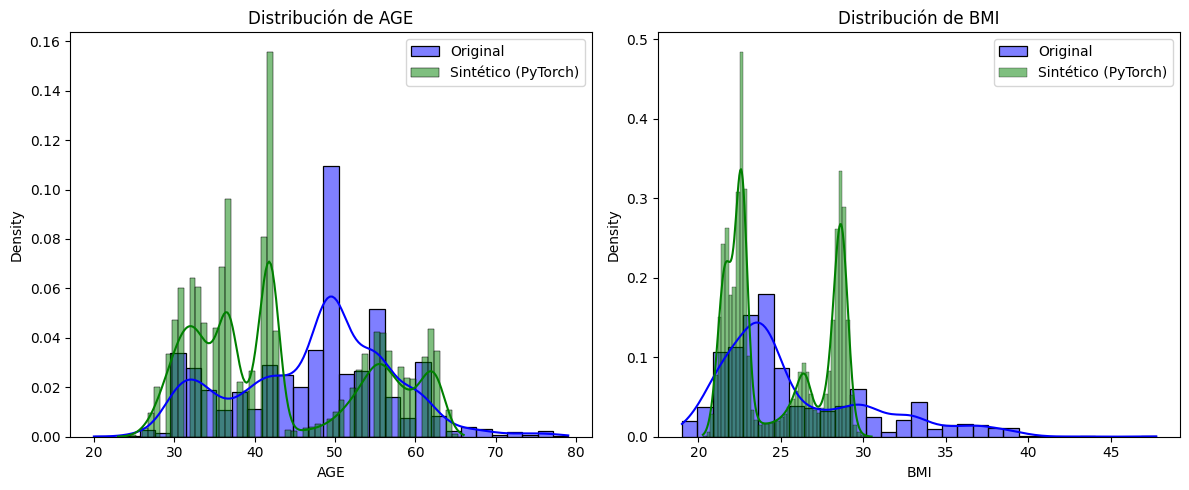


Finalizado con PyTorch.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

from imblearn.over_sampling import SMOTE 

# --- Parámetros de la GAN y del Entrenamiento ---
LATENT_DIM = 100
EPOCHS = 0 
BATCH_SIZE = 64
SAMPLE_INTERVAL = 1 
LEARNING_RATE_G = 0.0002
LEARNING_RATE_D = 0.00001
BETA1 = 0.5 
SAVE_INTERVAL = 100

iteration = 3
generator_path = "/content/gdrive/My Drive/ResultCSV/Multi/generator_gan_pytorch.pth"
discriminator_path = "/content/gdrive/My Drive/ResultCSV/Multi/discriminator_gan_pytorch.pth"

# Configurar dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# --- Cargar el archivo CSV original ---
input_file = '/content/gdrive/My Drive/Datasets/datasetMulti.csv'
data = pd.read_csv(input_file)
# --- Eliminar columnas de identificación ---
data = data.drop(columns=['ID', 'No_Pation'])

# --- Estandatiza valores en las columnas CLASS y Gender ya que hay alguno ---
data['CLASS'] = data['CLASS'].astype(str).str.strip()
data['Gender'] = data['Gender'].astype(str).str.strip().str.upper()

# Mapear valores de 'Gender' a numéricos 
data['Gender'] = data['Gender'].map({'F': 0, 'M': 1})

# Mapear 'CLASS' (ahora 'CLASS') a valores numéricos 
class_mapping = {'N': 0, 'P': 1, 'Y': 2}
data['CLASS'] = data['CLASS'].map(class_mapping)

original_columns = data.columns.tolist()

# --- Verificar el conteo de clases antes de SMOTE ---
print("\n--- Conteo de valores para CLASS (Original antes de SMOTE): ---")
print(data['CLASS'].value_counts().sort_index())

# --- 2. Aplicar SMOTE para balancear las clases ---
print("\nIniciando balanceo con SMOTE...")

# Separar características (X) y variable objetivo (y)
X_smote = data.drop('CLASS', axis=1)
y_smote = data['CLASS']

# Definir la estrategia de muestreo para que todas tengan 844
sampling_strategy = {0: 844, 1: 844, 2: 844} 

#Se aplica SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)

# Recombinar los datos balanceados en un DataFrame para el preprocesamiento de la GAN
data_df = pd.DataFrame(X_resampled, columns=X_smote.columns)
data_df['CLASS'] = y_resampled

# --- Verificar el conteo de clases después de SMOTE ---
print("\n--- Conteo de valores para CLASS (Después de SMOTE): ---")
print(data_df['CLASS'].value_counts().sort_index())

# --- 3. Preprocesamiento ---
print("Iniciando preprocesamiento...")
processed_data_parts = []
scalers_dict = {}
column_info_for_generator_output = []

special_cols_log_scale = ['AGE', 'BMI']
diabetes_col = 'CLASS'
gender_col = 'Gender' # Nueva columna categórica

# B. Gender (One-Hot Encoding)
num_classes_gender = data_df[gender_col].nunique() # Debería ser 2 (M/F)
gender_one_hot = np.eye(num_classes_gender)[data_df[gender_col].astype(int)]
processed_data_parts.append(gender_one_hot)
column_info_for_generator_output.append({'name': gender_col, 'type': 'one_hot', 'num_classes': num_classes_gender})
print(f"Preprocesado {gender_col} con One-Hot Encoding. Shape: {gender_one_hot.shape}")

# C. Columnas con log1p + MinMaxScaler
for col_name in special_cols_log_scale:
    original_values = data_df[col_name].values.reshape(-1, 1)
    log_transformed_values = np.log1p(original_values)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(log_transformed_values)
    processed_data_parts.append(scaled_values)
    scalers_dict[col_name] = {'scaler': scaler, 'log_applied': True, 'original_min': original_values.min(), 'original_max': original_values.max()}
    column_info_for_generator_output.append({'name': col_name, 'type': 'scaled_continuous_sigmoid'})
    print(f"Preprocesado {col_name} con log1p + MinMaxScaler. Shape: {scaled_values.shape}")

# D. Otras columnas (MinMaxScaler para [0,1])

other_cols = [col for col in original_columns if col not in [gender_col] + special_cols_log_scale]
for col_name in other_cols:
    original_values = data_df[col_name].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(original_values)
    processed_data_parts.append(scaled_values)
    scalers_dict[col_name] = {'scaler': scaler, 'log_applied': False, 'original_min': original_values.min(), 'original_max': original_values.max()}
    column_info_for_generator_output.append({'name': col_name, 'type': 'scaled_continuous_sigmoid'})
    print(f"Preprocesado {col_name} con MinMaxScaler. Shape: {scaled_values.shape}")

X_train_processed_np = np.concatenate(processed_data_parts, axis=1).astype(np.float32)
DATA_DIM = X_train_processed_np.shape[1]
print(f"Forma final de los datos procesados (X_train_processed_np): {X_train_processed_np.shape}")

# Convertir datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_processed_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_resampled.astype(int), dtype=torch.long).to(device)
num_classes = len(np.unique(y_resampled))

# --- 3. Definir el modelo GAN (PyTorch) ---

class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes, data_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + n_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.BatchNorm1d(512, momentum=0.8),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.BatchNorm1d(1024, momentum=0.8),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.BatchNorm1d(2048, momentum=0.8),
            nn.Linear(2048, 4096),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.BatchNorm1d(4096, momentum=0.8),
            nn.Linear(4096, data_dim),
            nn.Sigmoid() # Salida general en [0,1]
        )

    def forward(self, z, class_onehot):
        x = torch.cat([z, class_onehot], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, data_dim, n_classes):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim + n_classes, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid() # Salida binaria (real/falso)
        )

    def forward(self, x, class_onehot):
        x = torch.cat([x, class_onehot], dim=1)
        return self.model(x)

# Inicializar generador y discriminador
generator = Generator(LATENT_DIM, num_classes, DATA_DIM).to(device)
discriminator = Discriminator(DATA_DIM, num_classes).to(device)

# Load models
generator.load_state_dict(torch.load(generator_path, map_location=device))
discriminator.load_state_dict(torch.load(discriminator_path, map_location=device))

# Función de pérdida
adversarial_loss = nn.BCELoss().to(device)

# Optimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G, betas=(BETA1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D, betas=(BETA1, 0.999))

print("\n--- Arquitectura del Generador (PyTorch) ---")
print(generator)
print("\n--- Arquitectura del Discriminador (PyTorch) ---")
print(discriminator)


# --- 4. Bucle de Entrenamiento (PyTorch) ---
print("\nIniciando entrenamiento de la GAN con PyTorch...")
d_loss_history = []
g_loss_history = []
d_acc_history = [] # Para la precisión del discriminador

for epoch in range(EPOCHS):
    perm = torch.randperm(X_train_tensor.size(0))
    X_train_shuffled = X_train_tensor[perm]
    y_train_shuffled = y_train_tensor[perm]

    d_loss_epoch = 0
    g_loss_epoch = 0
    num_batches = X_train_shuffled.size(0) // BATCH_SIZE
    for i in range(num_batches): 
        # ---------------------
        #  Entrenar Discriminador
        # ---------------------
        discriminator.train()
        generator.eval() 

        batch_classes = y_train_tensor[perm][i*BATCH_SIZE:(i+1)*BATCH_SIZE] 
        batch_classes_onehot = torch.nn.functional.one_hot(batch_classes, num_classes).float() 

        # Datos reales
        real_imgs = X_train_shuffled[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        real_classes = y_train_shuffled[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        real_classes_onehot = torch.nn.functional.one_hot(real_classes, num_classes).float()
        real_imgs += 0.1 * torch.randn_like(real_imgs)
        real_labels = torch.full((real_imgs.size(0), 1), 0.9, device=device)

        # Datos falsos
        noise = torch.randn(real_imgs.size(0), LATENT_DIM, dtype=torch.float32).to(device)
        fake_classes = torch.randint(0, num_classes, (real_imgs.size(0),), device=device)
        fake_classes_onehot = torch.nn.functional.one_hot(fake_classes, num_classes).float()
        fake_imgs = generator(noise, fake_classes_onehot)
        fake_imgs += 0.1 * torch.randn_like(fake_imgs)
        fake_labels = torch.full((fake_imgs.size(0), 1), 0.1, device=device)

        # Entrenar con datos reales
        optimizer_D.zero_grad()
        real_output = discriminator(real_imgs, real_classes_onehot)
        d_loss_real = adversarial_loss(real_output, real_labels)

        # Entrenar con datos falsos
        fake_output = discriminator(fake_imgs.detach(), fake_classes_onehot)
        d_loss_fake = adversarial_loss(fake_output, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss_epoch += d_loss.item()
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Entrenar Generador
        # ---------------------
        generator.train() 
        for _ in range(4):
          optimizer_G.zero_grad()
          #Generacion de datos con generator
          noise_g = torch.randn(BATCH_SIZE, LATENT_DIM, dtype=torch.float32).to(device) 
          gen_classes = torch.randint(0, num_classes, (BATCH_SIZE,), device=device)
          gen_classes_onehot = torch.nn.functional.one_hot(gen_classes, num_classes).float()
          gen_imgs_for_g = generator(noise_g, gen_classes_onehot)
          real_labels_for_g = torch.ones(gen_imgs_for_g.size(0), 1, dtype=torch.float32).to(device)
          #verifica dato creado en el discrimidar
          output_g = discriminator(gen_imgs_for_g, gen_classes_onehot)
          #Calcula la loss del generador
          g_loss = adversarial_loss(output_g, real_labels_for_g)
          g_loss_epoch += g_loss.item()
          g_loss.backward()
          optimizer_G.step()

    # Guardar el progreso al final de la época (promedio si se quiere)
    d_loss_history.append(d_loss_epoch / num_batches)
    g_loss_history.append(g_loss_epoch / (num_batches*4))

    if (epoch + 1) % SAVE_INTERVAL == 0:
        #torch.save(generator.state_dict(), generator_path)
        #torch.save(discriminator.state_dict(), discriminator_path)
        print(f"Modelos guardados en '{generator_path}' y '{discriminator_path}'")

    if (epoch + 1) % SAMPLE_INTERVAL == 0:
        print(f"{epoch + 1}/{EPOCHS} [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

# --- Guardar modelos entrenados ---
#torch.save(generator.state_dict(), generator_path)
#torch.save(discriminator.state_dict(), discriminator_path)
#print(f"Modelos guardados en '{generator_path}' y '{discriminator_path}'")

# --- Graficar historial de pérdidas ---
plt.figure(figsize=(10, 5))
plt.plot(d_loss_history, label='Discriminator Loss')
plt.plot(g_loss_history, label='Generator Loss')
plt.title("Historial de Pérdidas de la GAN (PyTorch)")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.savefig(f'/content/gdrive/My Drive/ResultCSV/Multi/gan_loss_history_pytorch_{EPOCHS}_{iteration}.png')
plt.show()


# --- 5. Generación y Postprocesamiento de Datos Finales (PyTorch) ---
print("\nGenerando datos sintéticos finales con PyTorch...")
num_samples_per_class = 50000  # Numero de datos a generar pr clase
num_classes = data_df['CLASS'].nunique()
generation_batch_size = 512

generator.eval()
all_class_labels = []
synthetic_df_final = pd.DataFrame()
all_generated_data_scaled = []

#Generacion de datos poor Batches
with torch.no_grad():
    for class_value in range(num_classes):
        samples_generated = 0
        while samples_generated < num_samples_per_class:
            current_batch_size = min(generation_batch_size, num_samples_per_class - samples_generated)
            noise = torch.randn(current_batch_size, LATENT_DIM, dtype=torch.float32).to(device)
            class_onehot = torch.zeros(current_batch_size, num_classes, device=device)
            class_onehot[:, class_value] = 1
            generated_batch_scaled = generator(noise, class_onehot).cpu().numpy()
            all_generated_data_scaled.append(generated_batch_scaled)
            all_class_labels.extend([class_value] * current_batch_size)
            samples_generated += current_batch_size


generated_data_scaled_final_np = np.concatenate(all_generated_data_scaled, axis=0)
all_class_labels = np.array(all_class_labels)

synthetic_df_final['CLASS'] = all_class_labels

#se reajustan los valores con el one_hot_encoding y se mapean lo datos devuelta a etiquetas Originales
current_col_idx_in_generated = 0
for col_info in column_info_for_generator_output:
    col_name = col_info['name']
    col_type = col_info['type']

    if col_type == 'one_hot':
        num_classes_other = col_info['num_classes']
        one_hot_part = generated_data_scaled_final_np[:, current_col_idx_in_generated : current_col_idx_in_generated + num_classes_other]
        decoded_classes = np.argmax(one_hot_part, axis=1)
        synthetic_df_final[col_name] = decoded_classes
        # Si 'Gender' o 'CLASS', mapear de nuevo a sus etiquetas originales si es necesario para la visualización/guardado
        if col_name == 'CLASS':
            # Invertir el mapeo {'N': 0, 'P': 1, 'Y': 2}
            reverse_class_mapping = {v: k for k, v in class_mapping.items()}
            synthetic_df_final[col_name] = synthetic_df_final[col_name].map(reverse_class_mapping)
        elif col_name == 'Gender':
            # Invertir el mapeo {'F': 0, 'M': 1}
            reverse_gender_mapping = {0: 'F', 1: 'M'}
            synthetic_df_final[col_name] = synthetic_df_final[col_name].map(reverse_gender_mapping)
        current_col_idx_in_generated += num_classes_other

    elif col_type == 'scaled_continuous_sigmoid':
        generated_values_scaled = generated_data_scaled_final_np[:, current_col_idx_in_generated : current_col_idx_in_generated + 1]
        current_col_idx_in_generated += 1

        s_info = scalers_dict[col_name]
        scaler_obj = s_info['scaler']
        inverted_values = scaler_obj.inverse_transform(generated_values_scaled)

        if s_info['log_applied']:
            inverted_values = np.expm1(inverted_values)
        if data_df[col_name].dtype == 'int64' or (data_df[col_name].dtype == 'float64' and np.all(data_df[col_name] == data_df[col_name].astype(int))):
            final_values = np.round(inverted_values)
        else:
            final_values = inverted_values

        final_values = np.clip(final_values, s_info['original_min'], s_info['original_max'])
        synthetic_df_final[col_name] = final_values.flatten().astype(data_df[col_name].dtype)

synthetic_df_final = synthetic_df_final[original_columns]


temp_df_for_balancing = synthetic_df_final.copy()
print("Value counts in temp_df_for_balancing['CLASS'] before balancing:")
print(temp_df_for_balancing['CLASS'].value_counts())

#se balancea lo generado en caso de no salir balanceado
balanced_synthetic = []
for class_value in range(num_classes):
    class_samples = temp_df_for_balancing[temp_df_for_balancing['CLASS'] == class_value]
    if len(class_samples) == 0:
        print(f"Warning: No synthetic samples found for class {class_value}. Skipping this class.")
        continue
    balanced_synthetic.append(class_samples.sample(n=num_samples_per_class, replace=True, random_state=42))
synthetic_df_final_balanced = pd.concat(balanced_synthetic).sample(frac=1, random_state=42).reset_index(drop=True)

reverse_class_mapping = {v: k for k, v in class_mapping.items()}
synthetic_df_final_balanced['CLASS'] = synthetic_df_final_balanced['CLASS'].map(reverse_class_mapping)

#Guarda los datos generados en un CSV
output_file_pytorch = f'/content/gdrive/My Drive/ResultCSV/Multi/generated_data_gan_pytorch_{EPOCHS}_{iteration}.csv'
synthetic_df_final_balanced.to_csv(output_file_pytorch, index=False)
print(f"\nDatos sintéticos generados y guardados en: {output_file_pytorch}")

# --- Mostrar algunas estadísticas de los datos generados (igual que antes) ---
print("\n--- Descripción de los datos originales: ---")
print(data_df.describe())
print("\n--- Descripción de los datos sintéticos (PyTorch): ---")
print(synthetic_df_final_balanced.describe())

print("\n--- Conteo de valores para CLASS (Original): ---")
print(data_df['CLASS'].value_counts(normalize=True).sort_index())
print("\n--- Conteo de valores para CLASS (Sintético - PyTorch): ---")
print(synthetic_df_final_balanced['CLASS'].value_counts(normalize=True).sort_index())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data_df['AGE'], ax=axes[0], color='blue', label='Original', kde=True, stat="density")
sns.histplot(synthetic_df_final_balanced['AGE'], ax=axes[0], color='green', label='Sintético (PyTorch)', kde=True, stat="density")
axes[0].set_title('Distribución de AGE')
axes[0].legend()

sns.histplot(data_df['BMI'], ax=axes[1], color='blue', label='Original', kde=True, stat="density")
sns.histplot(synthetic_df_final_balanced['BMI'], ax=axes[1], color='green', label='Sintético (PyTorch)', kde=True, stat="density")
axes[1].set_title('Distribución de BMI')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ResultCSV/Multi/generated_data_distributions_comparison_pytorch_{EPOCHS}_{iteration}.png')
plt.show()

print("\nFinalizado con PyTorch.")


--- Iniciando comparación de distribuciones (Reales vs. Sintéticas) ---

--- Estadísticas Descriptivas - Datos Originales (después de SMOTE) ---
            Gender          AGE         Urea          Cr        HbA1c  \
count  2532.000000  2532.000000  2532.000000  2532.00000  2532.000000   
mean      0.422986    47.431675     4.722186    64.96406     6.480341   
std       0.494131     9.647218     2.272983    42.60856     2.275678   
min       0.000000    20.000000     0.500000     6.00000     0.900000   
25%       0.000000    41.000000     3.594724    48.00000     4.992159   
50%       0.000000    49.000000     4.395874    59.00000     6.000000   
75%       1.000000    54.000000     5.254985    73.00000     7.200000   
max       1.000000    79.000000    38.900000   800.00000    16.000000   

              Chol           TG          HDL          LDL         VLDL  \
count  2532.000000  2532.000000  2532.000000  2532.000000  2532.000000   
mean      4.558682     2.015410     1.201948    

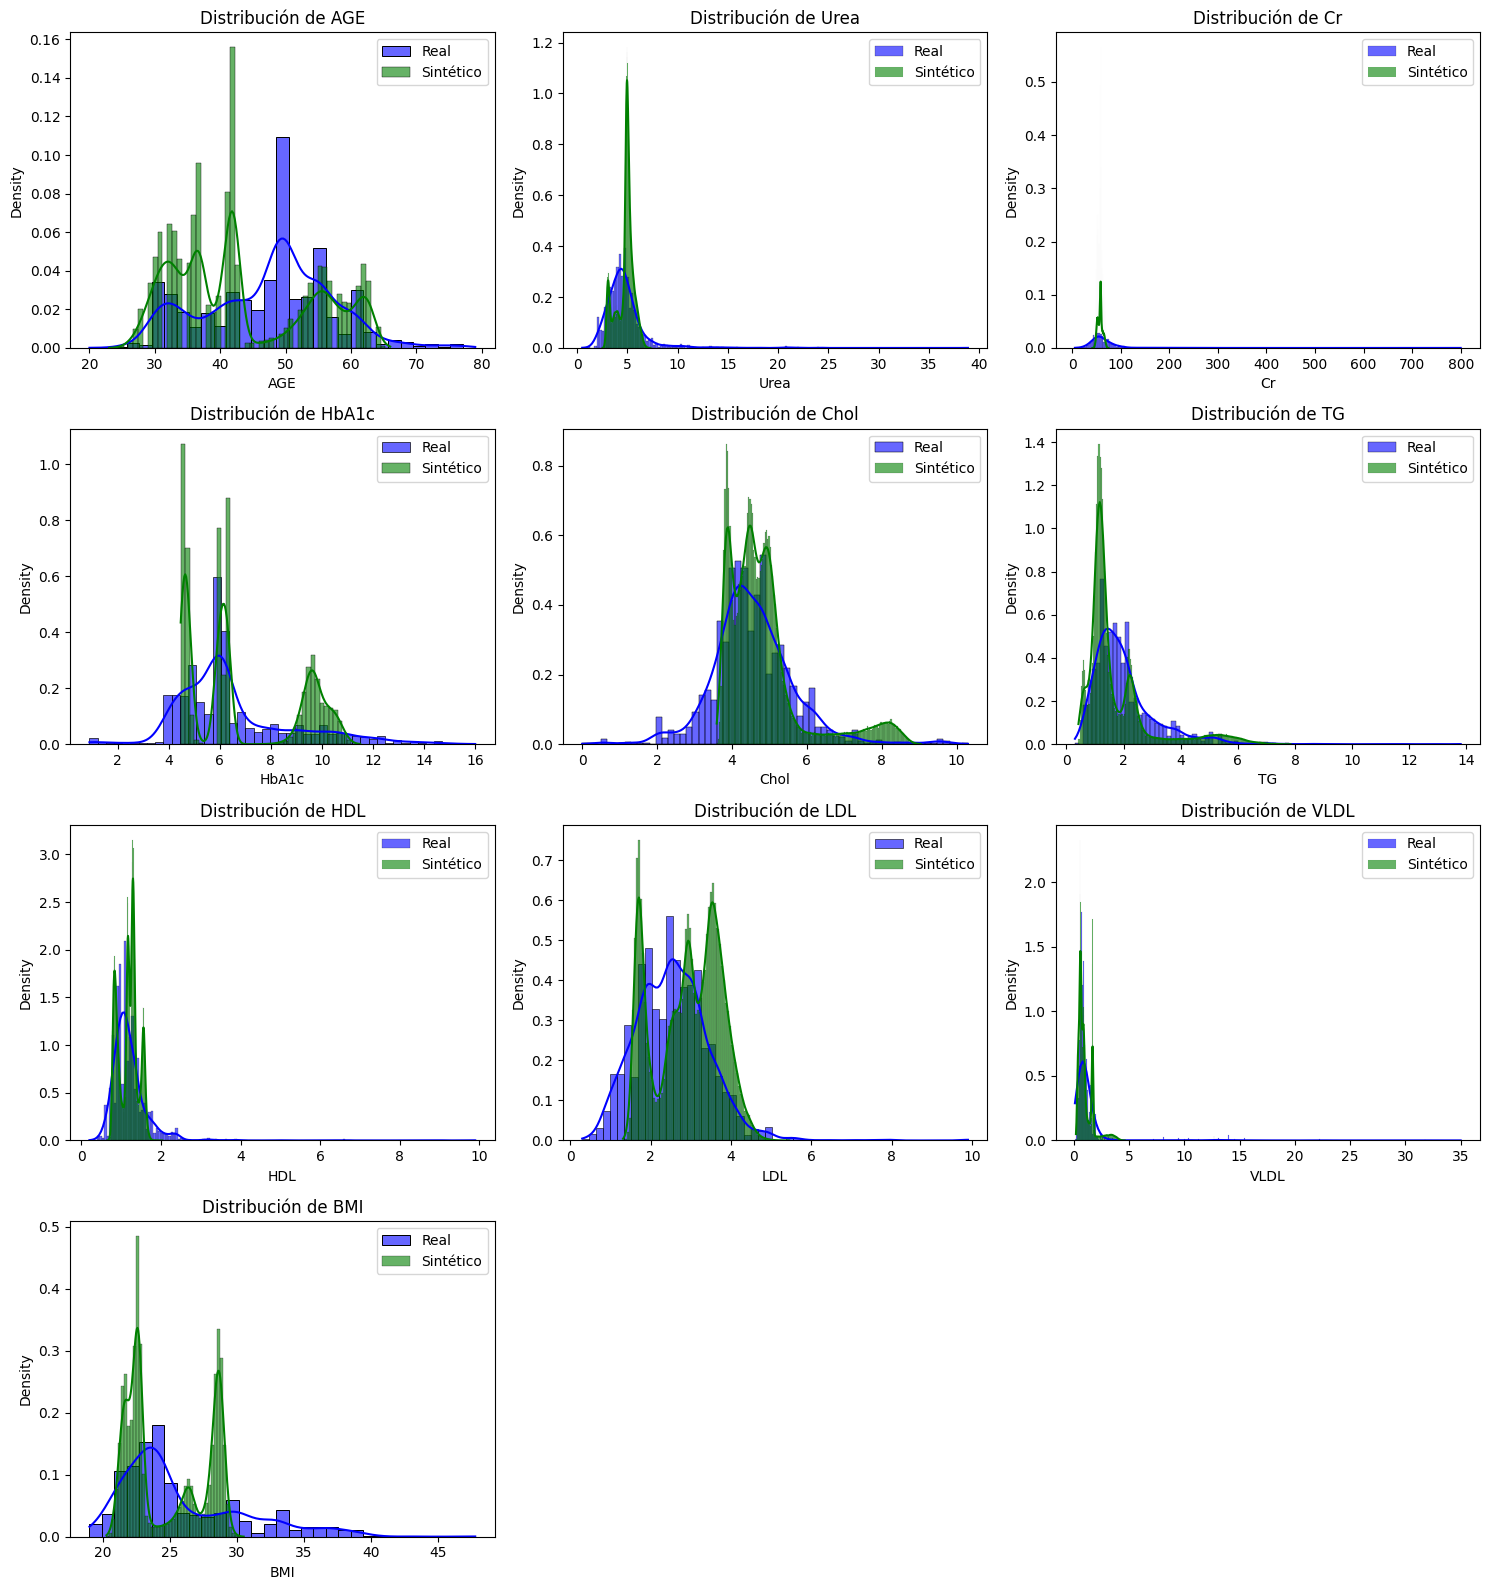


--- Visualizando distribuciones categóricas ---


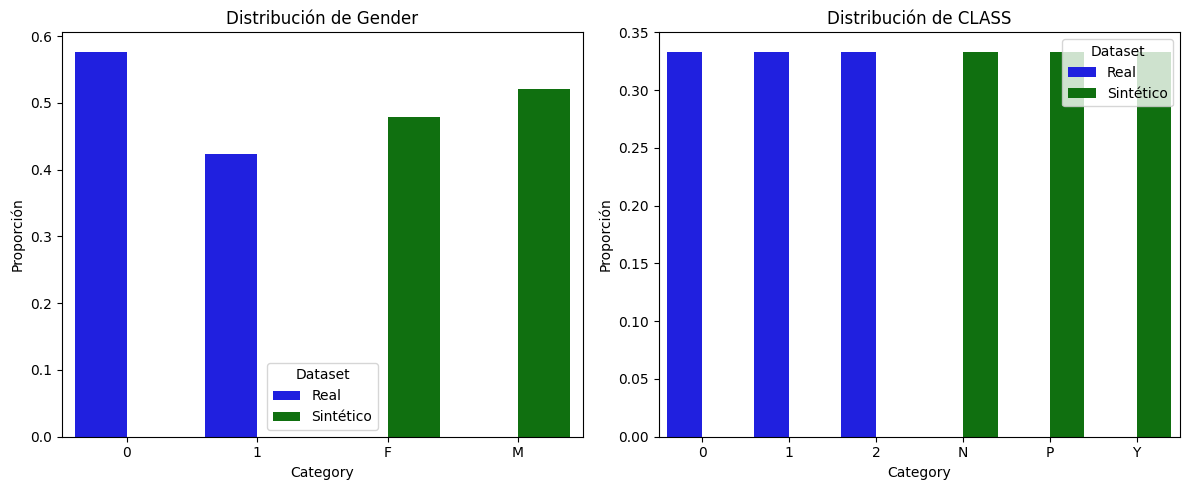


--- Fin de la comparación de distribuciones ---


In [ ]:
# --- Función para comparar y visualizar distribuciones ---
# esto es solo para verificacion manual para saber como estan resultando los datos generados
def compare_data_distributions(real_df, generated_df, numerical_cols, categorical_cols, output_prefix="comparison"):
    print("\n--- Iniciando comparación de distribuciones (Reales vs. Sintéticas) ---")

    # 1. Comparación de Estadísticas Descriptivas Generales
    print("\n--- Estadísticas Descriptivas - Datos Originales (después de SMOTE) ---")
    print(real_df.describe())
    print("\n--- Estadísticas Descriptivas - Datos Sintéticos ---")
    print(generated_df.describe())

    # 2. Comparación de Conteo de Valores (para Categóricas) y Varianzas (para Numéricas)
    print("\n--- Conteo de Clases / Valores (Categóricas) ---")
    for col in categorical_cols:
        print(f"\nColumna: {col}")
        print("Real:")
        print(real_df[col].value_counts(normalize=True).sort_index())
        print("Sintético:")
        print(generated_df[col].value_counts(normalize=True).sort_index())

    print("\n--- Varianzas de Columnas Numéricas ---")
    real_variances = real_df[numerical_cols].var()
    gen_variances = generated_df[numerical_cols].var()
    comparison_variances = pd.DataFrame({'Real_Variance': real_variances, 'Synthetic_Variance': gen_variances})
    print(comparison_variances)

    # 3. Visualización de Histogramas/KDE (para Numéricas)
    print("\n--- Visualizando distribuciones numéricas ---")
    num_plots_per_row = 3
    num_rows_numerical = (len(numerical_cols) + num_plots_per_row - 1) // num_plots_per_row
    fig_num, axes_num = plt.subplots(num_rows_numerical, num_plots_per_row, figsize=(5 * num_plots_per_row, 4 * num_rows_numerical))
    axes_num = axes_num.flatten() 

    for i, col in enumerate(numerical_cols):
        sns.histplot(real_df[col], ax=axes_num[i], color='blue', label='Real', kde=True, stat="density", alpha=0.6)
        sns.histplot(generated_df[col], ax=axes_num[i], color='green', label='Sintético', kde=True, stat="density", alpha=0.6)
        axes_num[i].set_title(f'Distribución de {col}')
        axes_num[i].legend()

    # Ocultar ejes vacíos si hay menos subplots que el espacio total
    for j in range(i + 1, len(axes_num)):
        fig_num.delaxes(axes_num[j])

    plt.tight_layout()
    plt.savefig(f"{output_prefix}_numerical_distributions.png")
    plt.show()

    # 4. Visualización de Gráficos de Barras (para Categóricas)
    print("\n--- Visualizando distribuciones categóricas ---")
    num_plots_per_row = 2
    num_rows_categorical = (len(categorical_cols) + num_plots_per_row - 1) // num_plots_per_row
    fig_cat, axes_cat = plt.subplots(num_rows_categorical, num_plots_per_row, figsize=(6 * num_plots_per_row, 5 * num_rows_categorical))
    axes_cat = axes_cat.flatten()

    for i, col in enumerate(categorical_cols):
        real_counts = real_df[col].value_counts(normalize=True).sort_index()
        gen_counts = generated_df[col].value_counts(normalize=True).sort_index()
        all_categories = real_counts.index.union(gen_counts.index)

        df_plot = pd.DataFrame({
            'Category': all_categories,
            'Real': real_counts.reindex(all_categories, fill_value=0),
            'Sintético': gen_counts.reindex(all_categories, fill_value=0)
        }).melt(id_vars='Category', var_name='Dataset', value_name='Proportion')

        sns.barplot(x='Category', y='Proportion', hue='Dataset', data=df_plot, ax=axes_cat[i], palette={'Real': 'blue', 'Sintético': 'green'})
        axes_cat[i].set_title(f'Distribución de {col}')
        axes_cat[i].set_ylabel('Proporción')

    for j in range(i + 1, len(axes_cat)):
        fig_cat.delaxes(axes_cat[j])

    plt.tight_layout()
    plt.savefig(f"{output_prefix}_categorical_distributions.png")
    plt.show()

    print("\n--- Fin de la comparación de distribuciones ---")

# Define tus columnas numéricas y categóricas
numerical_features_for_comparison = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']
categorical_features_for_comparison = ['Gender', 'CLASS']

# Llama a la función de comparación
compare_data_distributions(
    real_df=data_df, 
    generated_df=synthetic_df_final_balanced, 
    numerical_cols=numerical_features_for_comparison,
    categorical_cols=categorical_features_for_comparison,
    output_prefix="gan_data_comparison"
)